<a href="https://colab.research.google.com/github/victorviro/Deep_learning_python/blob/master/Vanishing_Exploding_gradients_problem_DNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training deep neural networks

[Here](https://github.com/victorviro/Deep_learning_python/blob/master/Introduction_artificial_neural_networks_keras.ipynb) we introduced artificial neural networks and trained our first deep neural networks. But they were shallow nets, with just a few hidden layers. What if you need to tackle a complex problem, such as detecting hundreds of types of objects in high-resolution images? You may need to train a much deeper DNN, perhaps with 10 layers or many more, each containing hundreds of neurons, linked by hundreds of thousands of connections. Training a deep DNN isn’t a walk in the park. Here are some of the problems you could run into:

- You may be faced with the tricky *vanishing gradients* problem or the related *exploding gradients* problem. This is when the gradients grow smaller and smaller, or larger and larger, when flowing backward through the DNN during training. Both of these problems make lower layers very hard to train.

- You might not have enough training data for such a large network, or it might be too costly to label.

- Training may be extremely slow.

- A model with millions of parameters would severely risk overfitting the training set, especially if there are not enough training instances or if they are too noisy.

In this notebook, we will explore the vanishing and exploding gradients problems and some of their most popular solutions. 

## The vanishing/exploding gradients problem

The backpropagation algorithm works by going from the output layer to the input layer, propagating the error gradient along the way. Once the algorithm has computed the gradient of the cost function with regard to each parameter in the network, it uses these gradients to update each parameter with a Gradient Descent step.

Unfortunately, gradients often get smaller and smaller as the algorithm progresses down to the lower layers. As a result, the Gradient Descent update leaves the lower layers connection weights virtually unchanged, and training never converges to a good solution. We call this the *vanishing gradients* problem. In some cases, the opposite can happen: the gradients can grow bigger and bigger until layers get insanely large weight updates and the algorithm diverges. This is the *exploding gradients* problem, which surfaces in recurrent neural networks. More generally, deep neural networks suffer from unstable gradients; different layers may learn at widely different speeds.

This unfortunate behavior was observed long ago, and it was one of the reasons deep neural networks were mostly abandoned in the early 2000s. It wasn’t clear what caused the gradients to be so unstable when training a DNN, but some light was shed in a [paper](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf) by Xavier Glorot and Yoshua Bengio in 2010. The authors found a few suspects, including the combination of the popular logistic sigmoid activation function and the weight initialization technique that was most popular at the time (i.e., a normal distribution with a mean of 0 and a standard deviation of 1). In short, they showed that with this activation function and this initialization scheme, the variance of the outputs of each layer is much greater than the variance of its inputs. Going forward in the network, the variance keeps increasing after each layer until the activation function saturates at the top layers. This saturation is actually made worse by the fact that the logistic function has a mean of 0.5, not 0 (the hyperbolic tangent function has a mean of 0 and behaves slightly better than the logistic function in deep networks).

Looking at the logistic activation function in the next figure.

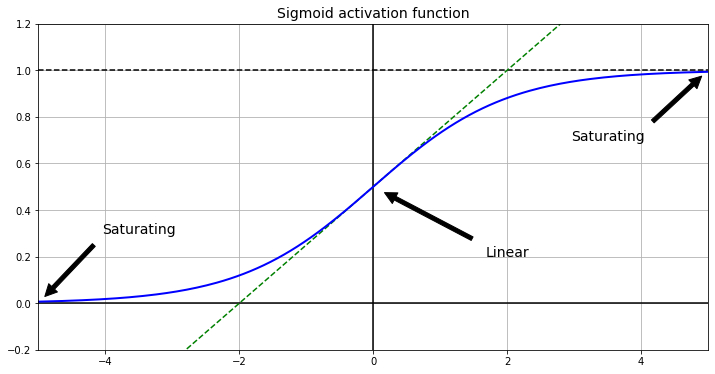

In [30]:
#@title
import numpy as np
import matplotlib.pyplot as plt

def logit(z):
    return 1 / (1 + np.exp(-z))

z = np.linspace(-5, 5, 200)


plt.figure(figsize=(12, 6))
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])
plt.show()

You can see that when inputs become large (negative or positive), the function saturates at 0 or 1, with a derivative extremely close to 0. Thus, when backpropagation kicks in it has virtually no gradient to propagate back through the network; and what little gradient exists keeps getting diluted as backpropagation progresses down through the top layers, so there is really nothing left for the lower layers.

### Glorot and He initialization

In their paper, Glorot and Bengio propose a way to significantly alleviate the unstable gradients problem. They point out that we need the signal to flow properly in both directions: in the forward direction when making predictions, and in the reverse direction when backpropagating gradients. We don’t want the signal to die out, nor do we want it to explode and saturate. For the signal to flow properly, the authors argue that we need the variance of the outputs of each layer to be equal to the variance of its inputs, and we need the gradients to have equal variance before and after flowing through a layer in the reverse direction. It is actually not possible to guarantee both unless the layer has an equal number of inputs and neurons (these numbers are called the *fan-in* and *fan-out* of the layer), but Glorot and Bengio proposed a good compromise that has proven to work very well in practice: the connection weights of each layer must be initialized randomly as described in the next equation:

Normal distribution with mean 0 and variance $\sigma^2=\frac{1}{\text{fan}_{\text{avg}}}$

Or a uniform distribution between $−r$ and $+r$, with $r=\sqrt{\frac{3}{\text{fan}_{\text{avg}}}}$

where $\text{fan}_{\text{avg}}=\frac{(\text{fan}_{\text{in}}+\text{fan}_{\text{out}})}{2}$.

This initialization strategy is called *Xavier/Glorot initialization*.

If you replace $\text{fan}_{\text{avg}}$ with $\text{fan}_{\text{in}}$ in the equation, you get an initialization strategy that Yann LeCun proposed in the 1990s. He called it *LeCun initialization*. This initialization is equivalent to Glorot initialization when $\text{fan}_{\text{in}}=\text{fan}_{\text{out}}$. Using Glorot initialization can speed up training considerably, and it is one of the tricks that led to the success of Deep Learning (it is usually used with the logistic, tanh and softmax activation functions).

But where did those formulas come from?
Suppose we have an input $X$ with $n$ components and a linear neuron with random weights $W$ that spits out a number $Y$. What’s the variance of Y? Well, we can write
$$Y=W_1X_1+...+W_nX_n$$

If the two variables $X_i$ and $W_i$ are independent, the variance of their product is given by

$$\text{Var}(W_iX_i)=E[X_i]^2\text{Var}(W_i)+E[W_i]^2\text{Var}(X_i)+\text{Var}(W_i)\text{Var}(X_i)$$

Now if our inputs and weights both have mean $0$, that simplifies to

$$\text{Var}(W_iX_i)=\text{Var}(W_i)\text{Var}(X_i)$$

Then if we make a further assumption that the $X_i$ and $W_i$ are all independent and identically distributed, then

$$\text{Var}(Y)=\text{Var}(\sum_{i=1}^{n}W_iX_i)=n\text{Var}(W_i)\text{Var}(X_i)$$

This is, the variance of the output is the variance of the input, but scaled by $n\text{Var}(W_i)$. So if we want the variance of the input and output to be the same, that means $n\text{Var}(W_i)$ should be 1. Which means the variance of the weights should be

$$\text{Var}(W_i)=\frac{1}{n}=\frac{1}{\text{fan}_{in}}$$

This is the *LeCun initialization*.

The *Glorot & Bengio's* formula needs a tiny bit more work. If you go through the same steps for the backpropagated signal, you find that you need

$$\text{Var}(W_i)=\frac{1}{\text{fan}_{out}}$$

to keep the variance of the input gradient and the output gradient the same. These two constraints can only be satisfied simultaneously if $\text{fan}_{in}=\text{fan}_{out}$, so as a compromise, Glorot & Bengio take the average of the two:

$$\text{Var}(W_i)=\frac{2}{\text{fan}_{in}+\text{fan}_{out}}$$

Some [papers](https://arxiv.org/pdf/1502.01852.pdf) have provided similar strategies for different activation functions. These strategies differ only by the scale of the variance and whether they use $\text{fan}_{\text{avg}}$ or $\text{fan}_{\text{in}}$.

The initialization strategy for the ReLU activation function (and its variants, including the ELU activation described shortly) is sometimes called *He initialization*, $\sigma^2=\frac{2}{\text{fan}_{\text{in}}}$
. The SELU activation function will be explained later in this chapter. It should be used with LeCun initialization (preferably with a normal distribution).

By default, Keras uses Glorot initialization with a uniform distribution. When creating a layer, you can change this to He initialization by setting `kernel_initializer="he_uniform"` or `kernel_initializer="he_normal"` like this:


In [31]:
import keras

keras.layers.Dense(10, activation="relu", kernel_initializer="he_normal")

If you want He initialization with a uniform distribution but based on $\text{fan}_{\text{avg}}$ rather than $\text{fan}_{\text{in}}$ , you can use the `VarianceScaling` initializer like this:

In [32]:
he_avg_init = keras.initializers.VarianceScaling(scale=2., mode='fan_avg',
                                                 distribution='uniform')
keras.layers.Dense(10, activation="relu", kernel_initializer=he_avg_init)

The following built-in initializers are available as part of the [`keras.initializers`](https://keras.io/api/layers/initializers/) module:

In [33]:
[name for name in dir(keras.initializers) if not name.startswith("_")]

['Constant',
 'Identity',
 'Initializer',
 'K',
 'Ones',
 'Orthogonal',
 'RandomNormal',
 'RandomUniform',
 'TruncatedNormal',
 'VarianceScaling',
 'Zeros',
 'absolute_import',
 'constant',
 'deserialize',
 'deserialize_keras_object',
 'division',
 'get',
 'glorot_normal',
 'glorot_uniform',
 'he_normal',
 'he_uniform',
 'identity',
 'lecun_normal',
 'lecun_uniform',
 'normal',
 'np',
 'one',
 'ones',
 'orthogonal',
 'print_function',
 'random_normal',
 'random_uniform',
 'serialize',
 'serialize_keras_object',
 'six',
 'truncated_normal',
 'uniform',
 'zero',
 'zeros']

### Nonsaturating activation functions

One of the insights in the paper by Glorot and Bengio was that the problems with unstable gradients were in part due to a poor choice of the activation function. Until then most people had assumed that the sigmoid activation function was an excellent choice. But it turns out that other activation functions behave much better in deep neural networks. In particular, the ReLU activation function, mostly because it does not saturate for positive values (and because it is fast to compute).

Remember that a function $f$ is non-saturating iff $|\lim_{z\to-\infty} f(z)|=+\infty$ and $|\lim_{z\to\infty} f(z)|=+\infty$, and $f$ is saturating iff $f$ is not non-saturating. The sigmoid activation function (previous figure) is saturating, because it squashes real numbers to range between [0,1].


The following built-in activations are available as part of the `keras.activations` module:




In [34]:
[m for m in dir(keras.activations) if not m.startswith("_")]

['K',
 'Layer',
 'absolute_import',
 'deserialize',
 'deserialize_keras_object',
 'division',
 'elu',
 'exponential',
 'get',
 'hard_sigmoid',
 'linear',
 'print_function',
 'relu',
 'selu',
 'serialize',
 'sigmoid',
 'six',
 'softmax',
 'softplus',
 'softsign',
 'tanh',
 'warnings']

#### RELU and variants

The Rectified Linear Unit (ReLU) activation function, which is defined as $f(z)=\text{max}(0,z)$ is non-saturating because $\lim_{z\to\infty} f(z)=+\infty$.



Unfortunately, the ReLU activation function is not perfect. It suffers from a problem known as the *dying ReLUs*: during training, some neurons effectively “die”, meaning they stop outputting anything other than 0. In some cases, you may find that half of your network’s neurons are dead, especially if you used a large learning rate. A neuron dies when its weights get tweaked in such a way that the weighted sum of its inputs are negative for all instances in the training set. When this happens, it just keeps outputting zeros, and Gradient Descent does not affect it anymore because the gradient of the ReLU function is zero when its input is negative.

To solve this problem, you may want to use a variant of the ReLU function, such as the *leaky ReLU*. This function is defined as $\text{LeakyReLU}_{\alpha}(z) = \text{max}(\alpha z, z)$ (see the next figure). The hyperparameter $\alpha$ defines how much the function “leaks”: it is the slope of the function for $z < 0$ and is typically set to 0.01. This small slope ensures that leaky ReLUs never die; they can go into a long coma, but they have a chance to eventually wake up. A [paper](https://arxiv.org/abs/1505.00853) in 2015 compared several variants of the ReLU activation function, and one of its conclusions was that the leaky variants always outperformed the strict ReLU activation function. In fact, setting $\alpha = 0.2$ (a huge leak) seemed to result in better performance than $\alpha = 0.01$ (a small leak). The paper also evaluated the *randomized leaky ReLU* (RReLU), where $\alpha$ is picked randomly in a given range during training and is fixed to an average value during testing. RReLU also performed fairly well and seemed to act as a regularizer (reducing the risk of overfitting the training set). Finally, the paper evaluated the *parametric leaky* ReLU (PReLU), where α is authorized to be learned during training (instead of being a hyperparameter, it becomes a parameter that can be modified by backpropagation like any other parameter). PReLU was reported to strongly outperform ReLU on large image datasets, but on smaller datasets it runs the risk of overfitting the training set.


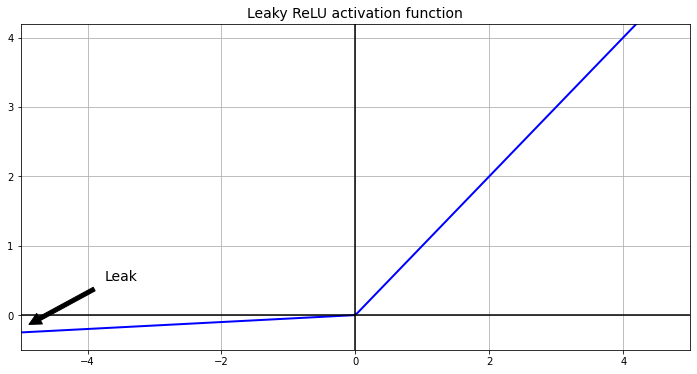

In [35]:
#@title
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

plt.figure(figsize=(12, 6))
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])
plt.show()

To use the leaky ReLU activation function, create a `LeakyReLU` layer and add it to your model just after the layer you want to apply it.

Let's train a neural network on [Fashion MNIST](https://www.kaggle.com/zalando-research/fashionmnist) dataset using the Leaky ReLU/PRELU:

In [36]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0

from sklearn.model_selection import train_test_split
# Split the data
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size=0.1, shuffle= True)

In [37]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(), #keras.layers.PReLU()
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(), #keras.layers.PReLU()
    keras.layers.Dense(10, activation="softmax")
])

In [38]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [39]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Train on 54000 samples, validate on 6000 samples
Epoch 1/10
54000/54000 [==============================] - 4s 72us/step - loss: 1.3223 - accuracy: 0.6001 - val_loss: 0.9120 - val_accuracy: 0.7040
Epoch 2/10
54000/54000 [==============================] - 4s 77us/step - loss: 0.7917 - accuracy: 0.7411 - val_loss: 0.7281 - val_accuracy: 0.7640
Epoch 3/10
54000/54000 [==============================] - 4s 70us/step - loss: 0.6755 - accuracy: 0.7767 - val_loss: 0.6504 - val_accuracy: 0.7870
Epoch 4/10
54000/54000 [==============================] - 4s 68us/step - loss: 0.6172 - accuracy: 0.7959 - val_loss: 0.6032 - val_accuracy: 0.8025
Epoch 5/10
54000/54000 [==============================] - 4s 68us/step - loss: 0.5800 - accuracy: 0.8069 - val_loss: 0.5726 - val_accuracy: 0.8107
Epoch 6/10
54000/54000 [==============================] - 4s 70us/step - loss: 0.5532 - accuracy: 0.8147 - val_loss: 0.5505 - val_accuracy: 0.8185
Epoch 7/10
54000/54000 [==============================] - 4s 69us/ste

The following built-in variants of RELU activations are available as part of the `keras.layers` module:

In [40]:
[m for m in dir(keras.layers) if "relu" in m.lower()]

['LeakyReLU', 'PReLU', 'ReLU', 'ThresholdedReLU']

#### ELU and variants

A [paper](https://arxiv.org/abs/1511.07289) by Djork-Arné Clevert in 2015 proposed a new activation function called the *exponential linear unit* (ELU) that outperformed all the ReLU variants in their experiments: training time was reduced, and the neural network performed better on the test set. The next equation shows its definition.

$$\text{ELU}_{\alpha}(z) = \begin{cases}
              \alpha(e^{z}-1) & \text{if} z < 0,\\
              z & \text{if } z \geq 0.
\end{cases}$$

The next figure graphs the function.



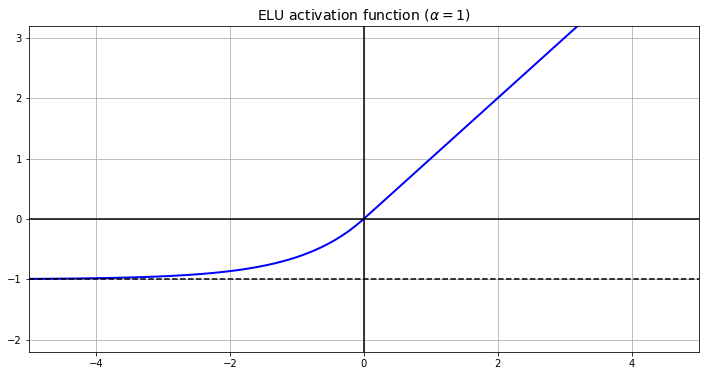

In [41]:
#@title
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

plt.figure(figsize=(12, 6))
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])
plt.show()

The ELU activation function looks a lot like the ReLU function, with a few major differences:

- It takes on negative values when $z < 0$, which allows the unit to have an average output closer to 0 and helps alleviate the vanishing gradients problem. The hyperparameter $\alpha$ defines the value that the ELU function approaches when $z$ is a large negative number. It is usually set to 1, but you can tweak it like any other hyperparameter.

- It has a nonzero gradient for $z < 0$, which avoids the dead neurons problem.

- If $\alpha=1$ then the function is smooth everywhere, including around $z = 0$, which helps speed up Gradient Descent since it does not bounce as much to the left and right of $z = 0$.

The main drawback of the ELU activation function is that it is slower to compute than the ReLU function and its variants (due to the use of the exponential function). Its faster convergence rate during training compensates for that slow computation, but still, at test time an ELU network will be slower than a ReLU network.

Implementing ELU in TensorFlow is trivial, just specify the activation function when building each layer:

In [42]:
keras.layers.Dense(10, activation="elu")

Then, a [paper](https://arxiv.org/abs/1706.02515) by Günter Klambauer in 2017 introduced the Scaled ELU (SELU) activation function: as its name suggests, it is a scaled variant of the ELU activation function. The authors showed that if you build a neural network composed exclusively of a stack of dense layers, and if all hidden layers use the SELU activation function, then the network will *self-normalize*: the output of each layer will tend to preserve a mean of 0 and standard deviation of 1 during training, which solves the vanishing/exploding gradients problem. As a result, the SELU activation function often significantly outperforms other activation functions for such neural nets (especially deep ones). There are, however, a few conditions for self-normalization to happen (see the paper for the mathematical justification):

- The input features must be standardized (mean 0 and standard deviation 1).

- Every hidden layer’s weights must be initialized with LeCun normal initialization. In Keras, this means setting `kernel_initializer="lecun_normal"`.

- The network’s architecture must be sequential. Unfortunately, if you try to use SELU in nonsequential architectures, such as recurrent networks or networks with skip connections (i.e., connections that skip layers, such as in Wide & Deep nets), self-normalization will not be guaranteed, so SELU will not necessarily outperform other activation functions.

- The paper only guarantees self-normalization if all layers are dense, but some researchers have noted that the SELU activation function can improve performance in convolutional neural nets as well.

Unfortunately, the self-normalizing property of the SELU activation function is easily broken: you cannot use $l_1$ or $l_2$ regularization, regular dropout, max-norm, skip connections, or other non-sequential topologies (so recurrent neural networks won't self-normalize). However, in practice, it works quite well with sequential CNNs. If you break self-normalization, SELU will not necessarily outperform other activation functions.

The next figure graphs the function.





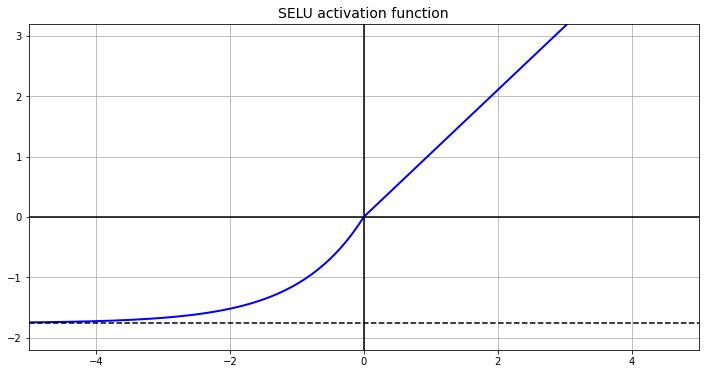

In [43]:
#@title
from scipy.special import erfc

# alpha and scale to self normalize with mean 0 and standard deviation 1 (equation 14 in the paper):
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)

def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

plt.figure(figsize=(12, 6))
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title("SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])
plt.show()

By default, the SELU hyperparameters (scale and alpha) are tuned in such a way that the mean output of each neuron remains close to 0, and the standard deviation remains close to 1 (assuming the inputs are standardized with mean 0 and standard deviation 1 too). Using this activation function, even a 1000 layer deep neural network preserves roughly mean 0 and standard deviation 1 across all layers, avoiding the exploding/vanishing gradients problem:

In [44]:
np.random.seed(42)
Z = np.random.normal(size=(500, 100)) # standardized inputs
for layer in range(1000):
    W = np.random.normal(size=(100, 100), scale=np.sqrt(1 / 100)) # LeCun initialization
    Z = selu(np.dot(Z, W))
    means = np.mean(Z, axis=0).mean()
    stds = np.std(Z, axis=0).mean()
    if layer % 100 == 0:
        print("Layer {}: mean {:.2f}, std deviation {:.2f}".format(layer, means, stds))

Layer 0: mean -0.00, std deviation 1.00
Layer 100: mean 0.02, std deviation 0.96
Layer 200: mean 0.01, std deviation 0.90
Layer 300: mean -0.02, std deviation 0.92
Layer 400: mean 0.05, std deviation 0.89
Layer 500: mean 0.01, std deviation 0.93
Layer 600: mean 0.02, std deviation 0.92
Layer 700: mean -0.02, std deviation 0.90
Layer 800: mean 0.05, std deviation 0.83
Layer 900: mean 0.02, std deviation 1.00


To use the SELU activation, set `activation="selu"` and `kernel_initializer="lecun_normal"` when creating a layer:

In [45]:
keras.layers.Dense(10, activation="selu",
                   kernel_initializer="lecun_normal")

Let's create a neural net for the Fashion MNIST dataset with 100 hidden layers, using the SELU activation function:

In [46]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="selu",
                             kernel_initializer="lecun_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="selu",
                                 kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [47]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

Now let's train it. Do not forget to scale the inputs to mean 0 and standard deviation 1:

In [48]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Train on 54000 samples, validate on 6000 samples
Epoch 1/5
54000/54000 [==============================] - 36s 670us/step - loss: 1.1956 - accuracy: 0.5432 - val_loss: 0.7920 - val_accuracy: 0.6907
Epoch 2/5
54000/54000 [==============================] - 34s 623us/step - loss: 0.7471 - accuracy: 0.7182 - val_loss: 0.7962 - val_accuracy: 0.7222
Epoch 3/5
54000/54000 [==============================] - 34s 621us/step - loss: 0.7100 - accuracy: 0.7417 - val_loss: 0.6099 - val_accuracy: 0.7767
Epoch 4/5
54000/54000 [==============================] - 34s 621us/step - loss: 0.5829 - accuracy: 0.7862 - val_loss: 0.5884 - val_accuracy: 0.7803
Epoch 5/5
54000/54000 [==============================] - 33s 614us/step - loss: 0.5251 - accuracy: 0.8147 - val_loss: 0.5080 - val_accuracy: 0.8180


Now look at what happens if we try to use the ReLU activation function instead:

In [49]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu", kernel_initializer="he_normal"))

for layer in range(99):
    model.add(keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Train on 54000 samples, validate on 6000 samples
Epoch 1/5
54000/54000 [==============================] - 23s 426us/step - loss: 1.8492 - accuracy: 0.2554 - val_loss: 1.5562 - val_accuracy: 0.3985
Epoch 2/5
54000/54000 [==============================] - 22s 400us/step - loss: 1.3452 - accuracy: 0.4344 - val_loss: 0.9714 - val_accuracy: 0.5927
Epoch 3/5
54000/54000 [==============================] - 22s 408us/step - loss: 1.0464 - accuracy: 0.5687 - val_loss: 0.8770 - val_accuracy: 0.6633
Epoch 4/5
54000/54000 [==============================] - 21s 395us/step - loss: 0.8961 - accuracy: 0.6373 - val_loss: 0.8327 - val_accuracy: 0.6588
Epoch 5/5
54000/54000 [==============================] - 21s 398us/step - loss: 0.7600 - accuracy: 0.6954 - val_loss: 0.7094 - val_accuracy: 0.7182


Not great at all, we suffered from the vanishing/exploding gradients problem.

### Batch normalization

Although using He initialization along with ELU (or any variant of ReLU) can significantly reduce the danger of the vanishing/exploding gradients problems at the beginning of training, it doesn’t guarantee that they won’t come back during training.

In a [paper](https://arxiv.org/abs/1502.03167) in 2015, Sergey Ioffe and Christian Szegedy proposed a technique called *Batch Normalization* (BN) that addresses these problems. The technique consists of adding an operation in the model just before or after the activation function of each hidden layer. This operation simply zero-centers and normalizes each input, then scales and shifts the result using two new parameter vectors per layer: one for scaling, the other for shifting. In other words, the operation lets the model learn the optimal scale and mean of each of the layer’s inputs. In many cases, if you add a BN layer as the very first layer of your neural network, you do not need to standardize your training set (e.g., using a `StandardScaler`); the BN layer will do it for you (well, approximately, since it only looks at one batch at a time, and it can also rescale and shift each input feature).

In order to zero-center and normalize the inputs, the algorithm needs to estimate each input’s mean and standard deviation. It does so by evaluating the mean and standard deviation of the input over the current mini-batch (hence the name “Batch Normalization”). The whole operation is summarized step by step in the next equation.

\begin{cases}
\boldsymbol{\mu}_{B}=\frac{1}{m_B}\sum_{i=1}^{m_B}\boldsymbol{x}^{(i)}\\\\
\boldsymbol{\sigma}_{B}^2=\frac{1}{m_B}\sum_{i=1}^{m_B}(\boldsymbol{x}^{(i)}-\boldsymbol{\mu}_B)^2\\\\
\boldsymbol{\hat{x}}^{(i)}=\frac{\boldsymbol{x}^{(i)}-\boldsymbol{\mu}_B}{\sqrt{\boldsymbol{\sigma}_{B}^2+\epsilon}}\\\\
\boldsymbol{z}^{(i)}=\boldsymbol{\gamma} \otimes \boldsymbol{\hat{x}}^{(i)} + \boldsymbol{\beta}
\end{cases}


- $\boldsymbol{\mu}_{B}$ is the vector of input means, evaluated over the whole mini-batch B (it contains one mean per input).

- $\boldsymbol{\sigma}_{B}$ is the vector of input standard deviations, also evaluated over the whole mini-batch (it contains one standard deviation per input).

- $m_B$ is the number of instances in the mini-batch.

- $\boldsymbol{\hat{x}}^{(i)}$ is the vector of zero-centered and normalized inputs for instance $i$.

- $\boldsymbol{\gamma}$ is the output scale parameter vector for the layer (it contains one scale parameter per input).

- $\otimes$ represents element-wise multiplication (each input is multiplied by its corresponding output scale parameter).

- $\boldsymbol{\beta}$ is the output shift (offset) parameter vector for the layer (it contains one offset parameter per input). Each input is offset by its corresponding shift parameter.

- $\epsilon$ is a tiny number that avoids division by zero (typically $10^{-5}$). This is called a smoothing term.

- $\boldsymbol{z}^{(i)}$ is the output of the BN operation. It is a rescaled and shifted version of the inputs.

So during training, BN standardizes its inputs, then rescales and offsets them. Good! What about at test time? Well, it’s not that simple. Indeed, we may need to make predictions for individual instances rather than for batches of instances: in this case, we will have no way to compute each input’s mean and standard deviation. Moreover, even if we do have a batch of instances, it may be too small, or the instances may not be independent and identically distributed, so computing statistics over the batch instances would be unreliable. One solution could be to wait until the end of the training, then run the whole training set through the neural network and compute the mean and standard deviation of each input of the BN layer. These “final” input means and standard deviations could then be used instead of the batch input means and standard deviations when making predictions. However, most implementations of Batch Normalization estimate these final statistics during training by using a moving average of the layer’s input means and standard deviations. This is what Keras does automatically when you use the `BatchNormalization` layer. To sum up, four parameter vectors are learned in each batch-normalized layer: $\boldsymbol{\gamma}$ (the output scale vector) and $\boldsymbol{\beta}$ (the output offset vector) are learned through regular backpropagation, and $\boldsymbol{\mu}$ (the final input mean vector) and $\boldsymbol{\sigma}$ (the final input standard deviation vector) are estimated using an exponential moving average. Note that $\boldsymbol{\mu}$ and \boldsymbol{\sigma} are estimated during training, but they are used only after training (to replace the batch input means and standard deviations in the third equation).

Ioffe and Szegedy demonstrated that Batch Normalization considerably improved all the deep neural networks they experimented with, leading to a huge improvement in the ImageNet classification task (ImageNet is a large database of images classified into many classes, commonly used to evaluate computer vision systems). The vanishing gradients problem was strongly reduced, to the point that they could use saturating activation functions such as the tanh and even the logistic activation function. The networks were also much less sensitive to the weight initialization. The authors were able to use much larger learning rates, significantly speeding up the learning process. Specifically, they note that, applying to a state-of-the-art image classification model, Batch Normalization achieves the same accuracy with 14 times fewer training steps, and beats the original model by a significant margin. Finally, like a gift that keeps on giving, Batch Normalization acts like a regularizer, reducing the need for other regularization techniques (such as dropout).

Batch Normalization does, however, add some complexity to the model (although it can remove the need for normalizing the input data, as we discussed earlier). Moreover, there is a runtime penalty: the neural network makes slower predictions due to the extra computations required at each layer. So if you need predictions to be lightning-fast, you may want to check how well plain ELU + He initialization perform before playing with Batch Normalization.

**Note**: You may find that training is rather slow, because each epoch takes much more time when you use Batch Normalization. This is usually counterbalanced by the fact that convergence is much faster with BN, so it will take fewer epochs to reach the same performance. 

#### Implementing batch normalization in Keras


As with most things with Keras, implementing Batch Normalization is simple and intuitive. Just add a `BatchNormalization` layer before or after each hidden layer’s activation function, and optionally add a BN layer as well as the first layer in your model. For example, this model applies BN after every hidden layer and as the first layer in the model (after flattening the input images):

In [50]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="softmax")
])

In this tiny example with just two hidden layers, it’s unlikely that Batch Normalization will have a very positive impact; but for deeper networks, it can make a tremendous difference.

Let’s display the model summary:

In [51]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_9 (Flatten)          (None, 784)               0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 784)               3136      
_________________________________________________________________
dense_425 (Dense)            (None, 300)               235500    
_________________________________________________________________
batch_normalization_8 (Batch (None, 300)               1200      
_________________________________________________________________
dense_426 (Dense)            (None, 100)               30100     
_________________________________________________________________
batch_normalization_9 (Batch (None, 100)               400       
_________________________________________________________________
dense_427 (Dense)            (None, 10)               

As you can see, each BN layer adds four parameters per input: $\boldsymbol{\gamma}$, $\boldsymbol{\beta}$, $\boldsymbol{\mu}$ and $\boldsymbol{\sigma}$ (for example, the first BN layer adds 3,136 parameters, which is 4 × 784). The last two parameters, $\boldsymbol{\mu}$ and $\boldsymbol{\sigma}$, are the moving averages; they are not affected by backpropagation, so Keras calls them “non-trainable” (if you count the total number of BN parameters, 3136 + 1200 + 400, and divide by 2, you get 2368, which is the total number of non-trainable parameters in this model).


In [52]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [53]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Train on 54000 samples, validate on 6000 samples
Epoch 1/10
54000/54000 [==============================] - 7s 133us/step - loss: 0.9048 - accuracy: 0.6944 - val_loss: 0.6060 - val_accuracy: 0.7923
Epoch 2/10
54000/54000 [==============================] - 7s 128us/step - loss: 0.5942 - accuracy: 0.7956 - val_loss: 0.5293 - val_accuracy: 0.8167
Epoch 3/10
54000/54000 [==============================] - 7s 129us/step - loss: 0.5382 - accuracy: 0.8121 - val_loss: 0.4963 - val_accuracy: 0.8273
Epoch 4/10
54000/54000 [==============================] - 7s 129us/step - loss: 0.5082 - accuracy: 0.8229 - val_loss: 0.4705 - val_accuracy: 0.8372
Epoch 5/10
54000/54000 [==============================] - 7s 128us/step - loss: 0.4881 - accuracy: 0.8301 - val_loss: 0.4551 - val_accuracy: 0.8425
Epoch 6/10
54000/54000 [==============================] - 7s 128us/step - loss: 0.4691 - accuracy: 0.8356 - val_loss: 0.4434 - val_accuracy: 0.8450
Epoch 7/10
54000/54000 [==============================] - 7s 12

The authors of the BN paper argued in favor of adding the BN layers before the activation functions, rather than after (as we just did). There is some debate about this, as which is preferable seems to depend on the task, you can experiment with this too to see which option works best on your dataset. To add the BN layers before the activation functions, you must remove the activation function from the hidden layers and add them as separate layers after the BN layers. Moreover, since a Batch Normalization layer includes one offset parameter per input, you can remove the bias term from the previous layer (just pass `use_bias=False` when creating it):

In [54]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, kernel_initializer="he_normal", use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("elu"),
    keras.layers.Dense(100, kernel_initializer="he_normal", use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("elu"),
    keras.layers.Dense(10, activation="softmax")
])

In [55]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [56]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Train on 54000 samples, validate on 6000 samples
Epoch 1/10
54000/54000 [==============================] - 7s 131us/step - loss: 0.9399 - accuracy: 0.6890 - val_loss: 0.6535 - val_accuracy: 0.7882
Epoch 2/10
54000/54000 [==============================] - 7s 126us/step - loss: 0.6391 - accuracy: 0.7834 - val_loss: 0.5642 - val_accuracy: 0.8137
Epoch 3/10
54000/54000 [==============================] - 7s 126us/step - loss: 0.5735 - accuracy: 0.8037 - val_loss: 0.5205 - val_accuracy: 0.8240
Epoch 4/10
54000/54000 [==============================] - 7s 124us/step - loss: 0.5404 - accuracy: 0.8138 - val_loss: 0.4952 - val_accuracy: 0.8287
Epoch 5/10
54000/54000 [==============================] - 7s 125us/step - loss: 0.5155 - accuracy: 0.8209 - val_loss: 0.4780 - val_accuracy: 0.8352
Epoch 6/10
54000/54000 [==============================] - 7s 125us/step - loss: 0.4971 - accuracy: 0.8284 - val_loss: 0.4635 - val_accuracy: 0.8385
Epoch 7/10
54000/54000 [==============================] - 7s 13

The `BatchNormalization` class has quite a few hyperparameters you can tweak. The defaults will usually be fine, but you may occasionally need to tweak the `momentum`. This hyperparameter allows you to control how much of the statistics from the previous mini-batch to include when the update is calculated. It is used by the `BatchNormalization` layer when it updates the exponential moving averages; given a new value $\boldsymbol{v}$ (i.e., a new vector of input means or standard deviations computed over the current batch), the layer updates the running average $\boldsymbol{\hat{v}}$ using the following equation:

$$\boldsymbol{\hat{v}} \leftarrow  \boldsymbol{\hat{v}} \times\text{momentum}+\boldsymbol{v} \times (1-\text{momentum})$$


A good momentum value is typically close to 1; for example, 0.9, 0.99, or 0.999 (you want more 9s for larger datasets and smaller mini-batches). By default, this is kept high with a value of 0.99. This can be set to 0.0 to only use statistics from the current mini-batch

Another important hyperparameter is `axis`: it determines which axis should be normalized. It defaults to -1, meaning that by default it will normalize the last axis (using the means and standard deviations computed across the *other* axes). When the input batch is 2D (i.e., the batch shape is [*batch size, features*]), this means that each input feature will be normalized based on the mean and standard deviation computed across all the instances in the batch. For example, the first BN layer in the previous code example will independently normalize (and rescale and shift) each of the 784 input features. If we move the first BN layer before the `Flatten` layer, then the input batches will be 3D, with shape [*batch size, height, width*]; therefore, the BN layer will compute 28 means and 28 standard deviations (1 per column of pixels, computed across all instances in the batch and across all rows in the column), and it will normalize all pixels in a given column using the same mean and standard deviation. There will also be just 28 scale parameters and 28 shift parameters. If instead you still want to treat each of the 784 pixels independently, then you should set `axis=[1, 2]`.

Notice that the BN layer does not perform the same computation during training and after training: it uses batch statistics during training and the “final” statistics after training (i.e., the final values of the moving averages).


`BatchNormalization` has become one of the most-used layers in deep neural networks, to the point that it is often omitted in the diagrams, as it is assumed that BN is added after every layer. But a recent [paper](https://arxiv.org/abs/1901.09321) by Hongyi Zhang et al. may change this assumption: by using a novel *fixed-update* (fixup) weight initialization technique, the authors managed to train a very deep neural network (10000 layers!) without BN, achieving *state-of-the-art* performance on complex image classification tasks. As this is bleeding-edge research, however, you may want to wait for additional research to confirm this finding before you drop Batch Normalization.

### Gradient clipping

Neural networks are trained using the stochastic gradient descent optimization algorithm. This requires first the estimation of the loss on one or more training examples, then the calculation of the derivative of the loss, which is propagated backward through the network in order to update the weights. It is possible for the updates to the weights to be so large that the weights either overflow or underflow their numerical precision. In practice, the weights can take on the value of an “NaN” or “Inf” when they overflow or underflow and for practical purposes the network will be useless from that point forward, forever predicting NaN values as signals flow through the invalid weights.

The problem of exploding gradients is more common with recurrent neural networks, such as LSTMs given the accumulation of gradients unrolled over hundreds of input time steps.

A common solution to exploding gradients is to change the derivative of the error before propagating it backward through the network and using it to update the weights. By rescaling the error derivative, the updates to the weights will also be rescaled, dramatically decreasing the likelihood of an overflow or underflow.

There are two main methods for updating the error derivative; they are:

- Gradient Scaling.
- Gradient Clipping.

*Gradient scaling* involves normalizing the error gradient vector such that vector norm (magnitude) equals a defined value, such as 1.0. *Gradient clipping*  involves forcing the gradient values (element-wise) to a specific threshold (a minimum or maximum value) if the gradient exceeded an expected range. Together, these methods are often simply referred to as *gradient clipping*.


It is common to use the same gradient clipping configuration for all layers in the network. Nevertheless, there are examples where a larger range of error gradients are permitted in the output layer compared to hidden layers.




In Keras, two types of gradient clipping can be used: gradient norm scaling and gradient value clipping.

*Gradient norm scaling* involves changing the derivatives of the loss function to have a given vector norm when the $L_2$ vector norm (sum of the squared values) of the gradient vector exceeds a threshold value. For example, we could specify a norm of 1.0, meaning that if the vector norm for a gradient exceeds 1.0, then the values in the vector will be rescaled so that the norm of the vector equals 1.0.

This can be used in Keras by specifying the `clipnorm` argument on the optimizer; for example:

In [57]:
# configure sgd with gradient norm clipping
optimizer = keras.optimizers.SGD(clipnorm=1.0)

*Gradient value clipping* involves clipping the derivatives of the loss function to have a given value if a gradient value is less than a negative threshold or more than the positive threshold. For example, we could specify a norm of 01.0, meaning that if a gradient value was less than -1.0, it is set to -1.0 and if it is more than 1.0, then it will be set to 1.0.

This can be used in Keras by specifying the `clipvalue`  argument on the optimizer, for example:


In [58]:
# configure sgd with gradient value clipping
optimizer = keras.optimizers.SGD(clipvalue=1.0)

This optimizer will clip every component of the gradient vector to a value between –1.0 and 1.0. This means that all the partial derivatives of the loss (with regard to each trainable parameter) will be clipped between –1.0 and 1.0. The threshold is a hyperparameter you can tune. Note that it may change the orientation of the gradient vector. For instance, if the original gradient vector is [0.9, 100.0], it points mostly in the direction of the second axis; but once you clip it by value, you get [0.9, 1.0], which points roughly in the diagonal between the two axes. In practice, this approach works well. If you want to ensure that Gradient Clipping does not change the direction of the gradient vector, you should clip by norm by setting clipnorm instead of `clipvalue`. This will clip the whole gradient if its $l_2$ norm is greater than the threshold you picked. For example, if you set `clipnorm=1.0`, then the vector [0.9, 100.0] will be clipped to [0.00899964, 0.9999595], preserving its orientation but almost eliminating the first component. If you observe that the gradients explode during training (you can track the size of the gradients using TensorBoard), you may want to try both clipping by value and clipping by norm, with different thresholds, and see which option performs best on the validation set.